In [1]:
#### Keras implementation of NN's which we will look at MNIST with

from __future__ import print_function
import keras as keras 
import tensorflow as tf
#import scipy
#import h5py
import os
from matplotlib import pyplot as plt
import numpy as np
import time
#svhn_path="../Datasets/svhn"#"/Home/Adam/Research/Datasets/svhn"

# Hyper-parameters
batch_size = 128
num_classes = 10
epochs = 10

img_rows, img_cols = 32, 32
## where did you put mnist_transfer
path_to_root_file="/home/adam/Code/"
### making sure that we have the GPU to work on
gpus = tf.config.experimental.list_physical_devices('GPU')
#logical_gpus = tf.config.experimental.list_logical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  # I do not know why I have to do this but gpu does not work otherwise.
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


mean, variance 0.36348352 70.18035
---------------Load MNIST----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


mean, variance 1.1809415 74.36859
---------------Load MNIST-M----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


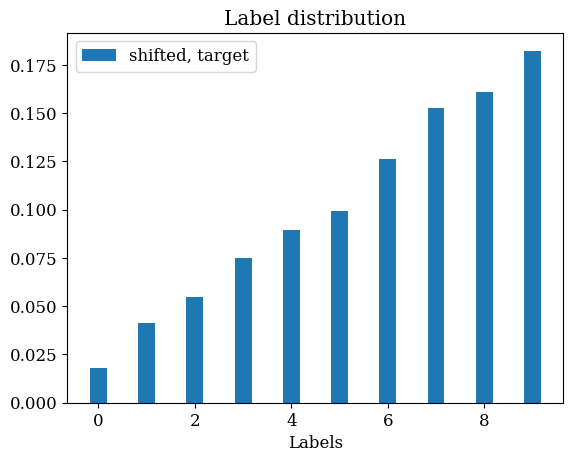

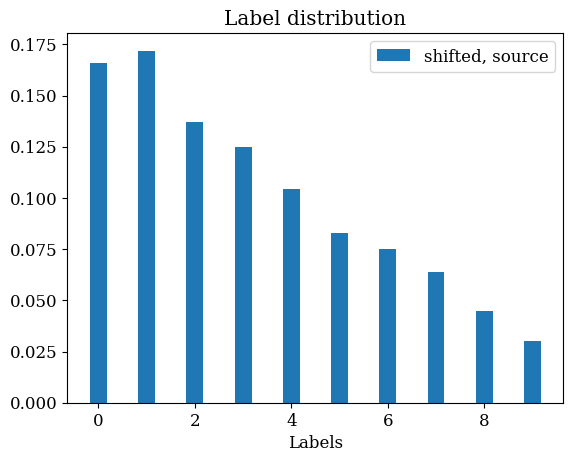

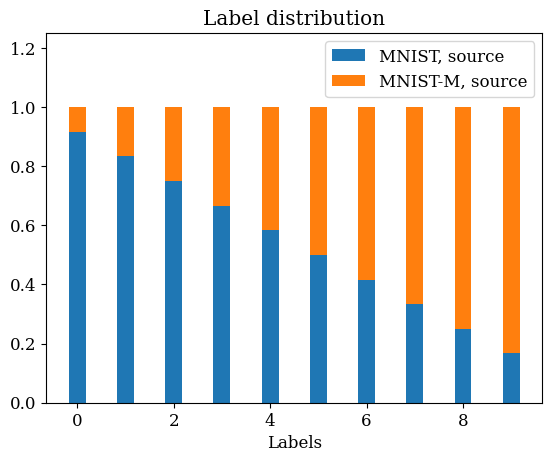

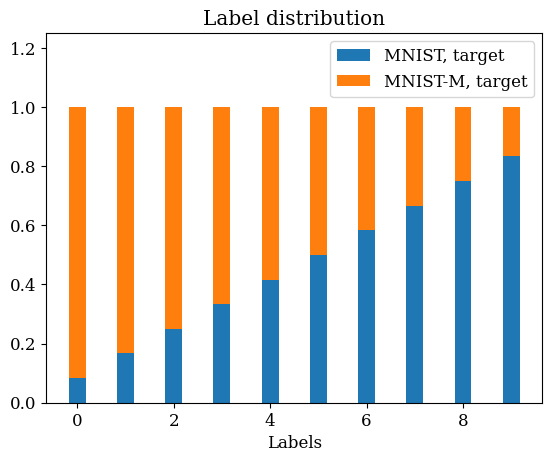

In [2]:

### load module, and also MNIST/MNIST-M
from importlib.machinery import SourceFileLoader
mymodule = SourceFileLoader('mnistm', path_to_root_file+'mnist_transfer/data/mnist_m.py').load_module()
mymodule2 = SourceFileLoader('mnist', path_to_root_file+'mnist_transfer/data/mnist.py').load_module()
import mnistm
import mnist
x_train, y_train, x_test, y_test = mnist.load_mnist()
x_train_m, y_train_m, x_test_m, y_test_m = mnistm.load_mnistm(y_train,y_test)


### load module
mymodule = SourceFileLoader('label_shift', path_to_root_file+'mnist_transfer/data/label_shift.py').load_module()

from label_shift import *
    
######### Here we use the functions from label_shift ################

###### Add train and test together and shift the distributions to create source and target distributions
### MNIST all data
x_full=np.append(x_train,x_test, axis=0)
y_full=np.append(y_train,y_test, axis=0)
### MNIST-M all data
x_full_m=np.append(x_train_m,x_test_m, axis=0)
y_full_m=np.append(y_train_m,y_test_m, axis=0)
#x_shift,y_shift,x_shift_target,y_shift_target =label_shift(x_train,y_train,1/2,7)
x_shift, y_shift, x_shift_target, y_shift_target =label_shift_linear(x_full,y_full,1/12,[0,1,2,3,4,5,6,7,8,9])
x_shift_m, y_shift_m,x_shift_target_m, y_shift_target_m=label_shift_linear(x_full_m,y_full_m,1/12,[0,1,2,3,4,5,6,7,8,9],decreasing=False)

plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_shift_target,"shifted, target")
plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_shift,"shifted, source")
plot_splitbars([0,1,2,3,4,5,6,7,8,9],y_shift,y_shift_m,"MNIST, source","MNIST-M, source")
plot_splitbars([0,1,2,3,4,5,6,7,8,9],y_shift_target,y_shift_target_m,"MNIST, target","MNIST-M, target")






In [58]:
def init_resnet_model(Binary=True):
    from keras.models import Sequential
    from keras.layers import Dense
    from tensorflow.keras.applications.resnet50 import ResNet50
    model = Sequential()
    ## no top as we want 10 classes for mnist etc
    model.add(ResNet50(include_top = False, pooling = 'avg', weights = None))
    if Binary:
        model.add(Dense(2, activation = 'softmax'))
    else:
        model.add(Dense(10, activation = 'softmax'))
    return model

# model=init_resnet_model(Binary=False)
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(x_full, y_full,
#            batch_size=batch_size,
#            epochs=10,
#            verbose=1,
#            validation_data=(x_full_m, y_full_m),
#           )



def init_FC_model(Binary=True):
    ### same as Dziugaite, to compare with rivasplata et al. in their case
    from keras.models import Sequential
    from keras.layers import Dense
    model = Sequential()
    model.add(Dense(1024,input_shape=(32,32,3), activation = 'relu'))
    model.add(Dense(600, activation = 'relu'))
    model.add(Dense(600, activation = 'relu'))
    if Binary:
        model.add(Dense(2, activation = 'softmax'))
    else:
        model.add(Dense(10, activation = 'softmax'))
    return model
model=init_FC_model(Binary=False)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
#print(x_full.shape)
#keras.utils.plot_model(model)
model.fit(x_full, y_full,batch_size=256,epochs=10,verbose=1,validation_data=(x_full_m, y_full_m))
#model.score(x_full_m,y_full_m)
def load_usps():
    import gzip
    import pickle
    ## copied and changed from https://github.com/JingWang18/Discriminative-Feature-Alignment/
    f = gzip.open('/home/adam/Code/Datasets/usps/usps_28x28.pkl', 'rb')
    data_set = pickle.load(f, encoding="bytes")
    f.close()
    img_train = data_set[0][0]
    label_train = data_set[0][1]
    img_test = data_set[1][0]
    label_test = data_set[1][1]
    ### do we need this??
    #inds = np.random.permutation(img_train.shape[0])
  
    #img_train = img_train[inds][:6562]
    #label_train = label_train[inds][:6562]
    
    img_train = img_train * 255
    img_test = img_test * 255
    img_train = img_train.reshape((img_train.shape[0], 28, 28, 1))
    img_test = img_test.reshape((img_test.shape[0], 28, 28, 1))

    #### test this part!!!
    img_train = np.pad(img_train,((0,0),(2,2),(2,2),(0,0))) #padding to make images 32x32 and not 28x28
    img_test = np.pad(img_test,((0,0),(2,2),(2,2),(0,0))) 
    
    ## normalising to unit variance
    sigma=np.std(img_train)
    img_train /= sigma 
    img_test /= sigma

    ## mean subtraction
    mu=np.mean(img_train)
    img_train -= mu
    img_test -= mu
    print('mean, variance', mu, sigma)
    
    ## expand to (N,32,32,3) so that we can compare the two datasets
 
    img_train=np.concatenate((img_train,img_train,img_train),axis=3)
    img_test=np.concatenate((img_test,img_test,img_test),axis=3) 
    print("---------------Load USPS----------------")
    print('Training set', img_train.shape, label_train.shape)
    #print('Validation set', x_val.shape, y_val.shape)
    print('Test set', img_test.shape, label_test.shape)
    print("\n")
    return img_train, label_train, img_test, label_test

#img_train, label_train, img_test, label_test = load_usps()

def train_and_eval_LR(x_train,y_train,x_test,y_test):
    from sklearn.linear_model import LogisticRegression
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    score = LR.score(x_test, y_test)
    return score


Epoch 1/10


ValueError: in user code:

    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:796 train_step
        loss = self.compiled_loss(
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    /usr/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /usr/lib/python3.9/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 10) and (None, 32, 32, 10) are incompatible


In [ ]:
##### Add the label shifted datasets to each other creating the source and target domain for task 2

##### calculate the label densities here
densities=[]
densities.append(np.sum(y_shift,axis=0))
densities.append(np.sum(y_shift_m,axis=0))
densities.append(np.sum(y_shift_target,axis=0))
densities.append(np.sum(y_shift_target_m,axis=0))
# mnist source, mnist-m source, mnist target,  mnist-m target
#print(densities)
TASK=2
if TASK==1:
    ###### label density shifted mnist
    x_source=x_shift
    y_source=y_shift
    x_target=x_shift_target
    y_target=y_shift_target
elif TASK==2:
    #### MIXED MNIST and MNIST-m
    L=len(densities[0])
    interdomain_densities = [[] for x in range(2)]
    for i in range(L):
        ## all densities are # in mnist over # in mnist-m
        interdomain_densities[0].append(densities[0][i]/densities[1][i])
        interdomain_densities[1].append(densities[2][i]/densities[3][i])
    print(interdomain_densities)
    x_source=np.append(x_shift,x_shift_m, axis=0)
    y_source=np.append(y_shift,y_shift_m, axis=0)
    x_target=np.append(x_shift_target,x_shift_target_m, axis=0)
    y_target=np.append(y_shift_target,y_shift_target_m, axis=0)
elif TASK==3:
    #### MNIST -> MNIST-m
    x_source=x_full
    y_source=y_full
    x_target=x_full_m
    y_target=y_full_m
elif TASK==4:
    #### MNIST->USPS
    x_source=x_full
    y_source=y_full
    x_target=x_usps
    y_target=y_usps
elif TASK==5:
    #### MNIST -> SVHN
    x_source=x_full
    y_source=y_full
    x_target=x_svhn
    y_target=y_svhn
elif TASK==6:
    x_source=x_chexpert
    y_source=y_chexpert
    x_source=x_chest14
    y_source=y_chest14


In [ ]:
########## testing images and such



#print(X_test)
#print("----------------------------------------------------")
#print(x_test)

#print(make_mnist_binary(y_train))
#plt.imshow(x_test_m[605]) 
#print(x_test_m[303])
#print(y_test_m[605])
#plt.imshow(x_test[605]) 
#print(x_test[303])
#print(y_test[605])

In [ ]:
import math
import sys
def mmd_rbf_linear(x,y,sigma_square):
    from sklearn import metrics
    """
    Here we want to compute the unbiased estimate of the MMD in linear time using the formula
    MMD^2_k(p,q)=2/n_s for i=1 to n_s/2 g_k(z_i)
    ,where z_i=(x^s_2i-1,x^s_2i,x^t_2i-1,x^t_2i) and
    g_k(z_i)= k(x^s_2i-1,x^s_2i)+k(x^t_2i-1,x^t_2i)-k(x^s_2i-1,x^t_2i)-k(x^s_2i,x^t_2i-1)
    """
    
    n_s=len(x)
    n=int(np.floor(n_s/2.0))
    
    ### make the data into a form which we can compute with, i.e on Nx1 vector form
    if x.ndim==1 or y.ndim==1:
        x=x.reshape(-1, 1)
        y=y.reshape(-1, 1)
    
    ##take out odd and even entries for the two vectors
    x_even=x[:n_s:2]
    x_odd=x[1:n_s:2]
    y_even=y[:n_s:2]
    y_odd=y[1:n_s:2]
    
    A=[]
    B=[]
    C=[]
    D=[]
    
    
    #### here we should do pairwise computation of the one off diagonal
    for i in range(n_s-1):
            A.append(kernel_scalar(x[i+1],x[i],sigma_square)[0])
            B.append(kernel_scalar(y[i+1],y[i],sigma_square)[0])
            C.append(-1*kernel_scalar(x[i],y[i+1],sigma_square)[0])
            D.append(-1*kernel_scalar(y[i+1],x[i],sigma_square)[0])
    A=np.array(A)
    B=np.array(B)
    C=np.array(C)
    D=np.array(D)
    #*(1/n) not needed?

    #print("A="+str(A))
    #print("B="+str(B))
    #print("C="+str(C))
    #print("D="+str(D))
    
    return (A+B+C+D).mean()
def mmd_rbf(x,y,sigma_square):
    from sklearn import metrics
    #### if needed for one dimensional data
    if x.ndim==1 or y.ndim==1:
        x=x.reshape(-1, 1)
        y=y.reshape(-1, 1)
    XX = metrics.pairwise.rbf_kernel(x, x, 1/sigma_square)
    YY = metrics.pairwise.rbf_kernel(y, y, 1/sigma_square)
    XY = metrics.pairwise.rbf_kernel(x, y, 1/sigma_square)
    A=np.diag(XX,1)
    B=np.diag(YY,1)
    C=-np.diag(XY,1)
    D=-np.diag(XY,1)
    #print("A="+str(A))
    #print("B="+str(B))
    #print("C="+str(C))
    #print("D="+str(D))
    
    return (np.diag(XX,1)+np.diag(YY,1)-np.diag(XY,1)-np.diag(XY,1)).mean()#XX.mean() + YY.mean() - 2 * XY.mean()

  
def kernel_scalar(x,y,sigma_square):
    return np.exp(-(1/(sigma_square)) * ((x - y) ** 2))
def kernel(x,y,sigma_square):
    return np.exp(-(1/(sigma_square)) * ((x - y) ** 2).sum(axis=1))
def kernel2(x,y,sigma_square):
    return np.exp(-np.sum(np.square(x-y),axis=1)/(sigma_square))
'''
#Test cases
A=np.ones(4)
B=np.linspace(1,4,4)
print(mmd_rbf_linear(A,B,1))
print(mmd_rbf(A.reshape(-1, 1),B.reshape(-1, 1),1))
print("------------------------------")
A=np.ones(9)
B=np.ones(9)+ [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
print(mmd_rbf_linear(A,B,1))
print(mmd_rbf(A.reshape(-1, 1),B.reshape(-1, 1),1))


#### test with normal dist. data we should see that the 
#### normal dist should be centered at about 0.17-0.2 on the x-axis
MMDsq=[]
MMDsq2=[]
for i in range(2000):
    samples = np.random.normal(0, 1, 200);
    samples2= np.random.normal(0,3*np.sqrt(2), 200);
    #MMDsq.append(mmd_rbf(mnist_flat,mnistm_flat,0.5))
    #mmds=[]
    #for sigma in sigmas:
            #mmds.append(mmd_rbf_linear(samples,samples2,sigma))
    MMDsq.append(mmd_rbf_linear(samples,samples2,0.5))
    MMDsq2.append(mmd_rbf(samples,samples2,0.5))
    #MMDsq.append(np.sum(mmds))
print("-------------------------------------------------------------")

print(np.mean(MMDsq))
print(np.mean(MMDsq2))
plt.hist(MMDsq,bins=20)

plt.show()
'''



In [ ]:
def flatten_images(x_train,x_train_m):
    ### flatten images into vectors to be able to compute MMD
    mnist_flat=[None]*len(x_train)
    mnistm_flat=[None]*len(x_train)
    for i in range(len(x_train)):
        mnist_flat[i]=tf.reshape(x_train[i],[-1])
        mnistm_flat[i]=tf.reshape(x_train_m[i],[-1])
    #print(np.array(mnist_flat).shape)
    #print(np.array(mnistm_flat).shape)
    return np.array(mnist_flat), np.array(mnistm_flat)




## flatten the mnist and mnist-m images and use the MMD to compute a metric between them
mnist_flat, mnistm_flat=flatten_images(x_train,x_train_m)




##### do this for a range of sigma and sum the results for an estimation of the true MMD

sigmas = [
      1e-6, 1e-5, 
      1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
      1e3, 1e4, 1e5, 1e6
  ]

mmdlist=[]

for sigma in sigmas:
    mmdlist.append(mmd_rbf(mnist_flat[:1000],mnistm_flat[:1000],sigma))
print(mmdlist)
finalmmd=np.sqrt(np.mean(mmdlist))
print(finalmmd)






In [ ]:



### load module
mymodule = SourceFileLoader('train', path_to_root_file+'mnist_transfer/experiments/training.py').load_module()
mymodule2 = SourceFileLoader('kl', path_to_root_file+'mnist_transfer/util/kl.py').load_module()
mymodule3 = SourceFileLoader('util', path_to_root_file+'mnist_transfer/util/misc.py').load_module()
mymodule4 = SourceFileLoader('SL', path_to_root_file+'mnist_transfer/experiments/SL_bound.py').load_module()
from kl import *
from train import *
from util import *
from SL import *
import pandas as pd
import pickle
import sys
import gc
import re

def read_weights(model,w_a,x_bound,y_bound,x_target,y_target,sigma,epsilon,alpha,Binary=False,Task=TASK):
    batch_size=128
    batches_per_epoch=np.ceil(len(y_target)/batch_size) ## should be 547
    epoch=1
    
    KLs=[]
    errors=[]
    targeterrors=[]
    epochs=[]
    
    sigma=sigma[0]*10**(-1*sigma[1])    
    
    ### Here we do something more intelligent to not have to hardcode the epoch amounts. 
    ### we parse the filenames and sort them in numerical order and then load the weights
    if Binary:
        path="posteriors/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))
    else:
        path="posteriors/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))
        
    #epochs = [] #list of 
    list1=[]
    list2=[]
    dirFiles = os.listdir(path) #list of directory files
    ## remove the ckpt.index and sort so that we get the epochs that are in the directory
    for files in dirFiles: #filter out all non checkpoints
        if '.ckpt.index' in files:
            name = re.sub('\.ckpt.index$', '', files)
            ### if it has a one it goes in one list and if it starts with a two it goes in the other
            if (name[0]=="1"):
                list1.append(name)
            elif (name[0]=="2"):
                list2.append(name)
            #epochs.append(name)
    #epochs.sort(key=lambda f: int(re.sub('\D', '', f)))
    list1.sort(key=lambda f: int(re.sub('\D', '', f)))
    num_batchweights=len(list1)
    list2.sort(key=lambda f: int(re.sub('\D', '', f)))
    list1.extend(list2)
    Ws=list1 ## vector of checkpoint filenames
    
    weight_updates=[]
    for i in Ws:
        #print(i)
        if i[0]=="1":
            if i[1]=="_":
                weight_updates.append(int(i[2:]))
    for i in list2:
        weight_updates.append((int(i[2:])+1)*batches_per_epoch)
   
    ### load the model and the weights
    for checkpoint in Ws:
        if Binary:
            model=init_MNIST_model_binary()
            model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
        else:
            model=init_MNIST_model()
            model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
        model.load_weights(path+"/"+str(checkpoint)+".ckpt").expect_partial()
        w_s=model.get_weights()
        
        ##### draw classifiers that are samples from the gaussian dists which define our posterior
        
        t = time.time()
        ## do some draws of the posterior
        w_s_draws=draw_classifier(w_s,sigma,num_classifiers=2)
       
        ## do some draws of the prior
        #if w_a is not None:
        #    w_a_draws=draw_classifier(w_a,sigma,num_classifiers=2)
        #else:
        #    print("Error: No prior weights were supplied!")
        #    sys.exit(-1)
          
        elapsed = time.time() - t
        print("Time spent drawing the classifiers: "+str(elapsed)+"\n")
   
    
        
        ###### for each pair of drawn prior and posterior we calculate the necessary parts of the bound 
        ###### and then average the result and return that
        k=0
        errorsum=0
        target_errorsum=0
        KLsum=0
        
        for i in w_s_draws:
            model.set_weights(i)
            errorsum+=((1-model.evaluate(x_bound,y_bound,verbose=0)[1]))#+errorsum*k)/(k+1)
            target_errorsum+=((1-model.evaluate(x_target,y_target,verbose=0)[1]))#+target_errorsum*k)/(k+1)
            #k+=1
        errorsum/=len(w_s_draws)
        target_errorsum/=len(w_s_draws)
        KLsum=estimate_KL(w_a,w_s,sigma)
        
        print("Iteration done with sigma:"+str(sigma)+" and epsilon:"+str(epsilon))
        KLs.append(KLsum)
        targeterrors.append(target_errorsum)
        errors.append(errorsum)
        ## this is needed because keras is bad and leaks memory; Or I am dumb and cannot see what I am doing wrong
        del model
        _ = gc.collect()
    
    #print("we made it here!!!!")
    #sys.exit(-1)
    
    return KLs,errors,targeterrors,Ws,Xvector

class stop_callback(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', value=0.001, verbose=0):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy')> self.value): # select the accuracy
            print("\n !!! training error threshold reached, no further training !!!")
            self.model.stop_training = True
            
class fast_checkpoints(tf.keras.callbacks.Callback):
    def __init__(self,checkpoint_path,save_freq):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.save_freq=save_freq
        self.filepath=checkpoint_path
        self.verbose=1
        self.save_best_only=False
        self.save_weights_only=True
    def on_train_batch_begin(self, batch, epoch, logs=None):
         if batch%self.save_freq==0:
            self.model.save_weights(self.filepath+"/1_"+str(batch)+".ckpt")
            print("\n Saved weights at the start of batch"+str(batch)+"\n")
            self.model.save_weights(self.filepath+"/1_"+str(batch)+".ckpt")
            
def train_posterior(alpha,x_train,y_train,prior_weights=None,x_test=[],y_test=[],save=True,epsilon=0.01,Task=2,Binary=False):
        
        TASK=Task
        batch_size=128
        
        ### x_test should be the whole of S for early stopping purposes
    
        checkpoint_path = "posteriors/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))
        if Binary:
            checkpoint_path = "posteriors/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))
        
        
        # Create a callback that saves the model's weights every epoch
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
        save_freq=547,   ### 547 = ceiling(70000/128) i.e training set for MNIST/MNIST-M,
        filepath=checkpoint_path+"/2_{epoch:0d}.ckpt", 
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
            ## tune when to save as needed for plots
        )
        fast_cp_callback =fast_checkpoints(checkpoint_path,45)
        stopping_callback=stop_callback(monitor='val_acc',value=1-epsilon)
    
        if Binary:
            M=init_MNIST_model_binary()
        else:
            M=init_MNIST_model()

        
            
        ## choose loss function, optimiser etc. and train
        
        M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
        ### load the prior weights
        if prior_weights is not None:
            M.set_weights(prior_weights)
        elif(alpha==0):
            ### save the rand. init as the prior
            prior_path="priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))+"/prior.ckpt"
            M.save_weights(prior_path)
        else:
            if Binary:
                prior_path="priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))+"/prior.ckpt"
                M.load_weights(prior_path).expect_partial()
            else:
                prior_path="priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))+"/prior.ckpt"
                M.load_weights(prior_path).expect_partial()
        
    
        if save:
            CALLBACK=[fast_cp_callback,stopping_callback]
        else:
            CALLBACK=[stopping_callback]
        ### train for one epoch with more checkpoints to be able to plot more there
        fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=1, 
           callbacks=CALLBACK,
           validation_data=(x_test, y_test),
           verbose=1,
                        )
        
        
        if save:
            CALLBACK=[cp_callback,stopping_callback]
        else:
            CALLBACK=[stopping_callback]
            
        fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=2000, # we should have done early stopping before this completes
           callbacks=CALLBACK,
           validation_data=(x_test, y_test),
           verbose=1,
                        )
        
        
         #### save the last posterior weights to disk
        epochs_trained=len(fit_info.history['loss'])
        if save:
            M.save_weights(checkpoint_path+"/2_"+str(epochs_trained)) ###### check if we need this; TODO!!!!!!
            
        #### save textfile with parameters, i.e. alpha ,epochs trained and epsilon
        if Binary:
            with open('posteriors/'+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+'/params.txt', 'w') as f:
                f.write('\n'.join([str(alpha), str(epsilon), str(epochs_trained)]))     
            f.close()
        else:
            with open('posteriors/'+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+'/params.txt', 'w') as f:
                f.write('\n'.join([str(alpha), str(epsilon), str(epochs_trained)]))     
            f.close()
        W=M.get_weights()
        return W
    
def train_prior(alpha,total_epochs,x_train=[],y_train=[],x_target=[],y_target=[],save=True,Task=2,Binary=False):
    TASK=Task
    checkpoint_path = "priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))
    
    if Binary:
        M=init_MNIST_model_binary()
        checkpoint_path = "priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))#+"/prior.ckpt"
    else:
        M=init_MNIST_model()
        
    fast_cp_callback =fast_checkpoints(checkpoint_path,10)
    if save:
            CALLBACK=[fast_cp_callback]
    else:
            CALLBACK=[]
            
            
    ## choose loss function, optimiser etc. and train
    M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
    fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           callbacks=CALLBACK,
           epochs=total_epochs,
           verbose=1,
                        )
    #### save the final prior weights to disk
    if save:
        M.save_weights(checkpoint_path+"/prior.ckpt")
    
 
    
    list1=[]
    
    dirFiles = os.listdir(checkpoint_path) #list of directory files
    
    ## remove the ckpt.index and sort so that we get the epochs that are in the directory
    for files in dirFiles: #filter out all non weights
        if '.ckpt.index' in files:
            name = re.sub('\.ckpt.index$', '', files)
            if (name[0]=="1"):
                list1.append(name)
        
    list1.sort(key=lambda f: int(re.sub('\D', '', f)))
    list1.append("prior")    ## add the final weights which has no number
    
    Ws=list1
    weight_updates=[]
    for i in Ws:
        if i[0]=="1":
            if i[1]=="_":
                weight_updates.append(int(i[2:]))
    weight_updates.append(int(np.ceil(len(y_train)/batch_size)))
    
    error=[]
    target_error=[]
    for checkpoint in Ws:
        if Binary:
            model=init_MNIST_model_binary()
            model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
        else:
            model=init_MNIST_model()
            model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
            
        model.load_weights(checkpoint_path+"/"+str(checkpoint)+".ckpt").expect_partial()
        target_error.append(1-model.evaluate(x_target,y_target,verbose=0)[1])
        error.append(1-model.evaluate(x_train,y_train,verbose=0)[1])
    
    if save:
        results=pd.DataFrame({'Weightupdates': weight_updates,
            'Trainerror': error,
            'targeterror':target_error,
            })
        with open(path_to_root_file+'mnist_transfer/'+checkpoint_path+"/results.pkl",'wb') as f:
            pickle.dump(results,f)
        f.close()
    
    return model.get_weights()
    
def read_and_prepare_results(alpha,x_bound,y_bound,x_target,y_target,sigma,delta,N,epsilon,Binary=False,Task=TASK):
    
    sigma_tmp=sigma
    sigma=sigma[0]*10**(-1*sigma[1])
    
    ## read params.txt for the desired alpha and get the parameters
    if Binary:
        with open('posteriors/'+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+'/params.txt', 'rb+') as f:
            params=f.readlines()
        f.close()
        prior_path="priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))+"/prior.ckpt"
        result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"
    else:
        with open('posteriors/'+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+'/params.txt', 'rb+') as f:
            params=f.readlines()
        f.close()
        prior_path="priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))+"/prior.ckpt"
        result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"
        
    epsilon=float(params[1])
    epochs_trained=int(params[2])
    
    # initialise model
    if Binary:
        M=init_MNIST_model_binary()
    else:
        M=init_MNIST_model()
    M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
    ### load the prior weights if there are any
    if alpha==0:
        ### do nothing, i.e take the random init
        w_a=M.get_weights()
    else:
        M.load_weights(prior_path).expect_partial()
        w_a=M.get_weights()
    
    # read the weights and calculate what is needed for the bound
    [KLs,errors,targeterrors,Ws,weight_updates]=read_weights(M,w_a,x_bound,y_bound,x_target,y_target,epochs_trained,sigma_tmp,epsilon,alpha,Binary=Binary,Task=TASK)    
    
    #print(KLs)
    #print(errors)
    #print(targeterrors)
    #print(Ws)
   
    bound=[]
    ### calculate the bound
    for i in range(len(weight_updates)):
        bound.append(calculate_bound(KLs[i],alpha,delta,N,errors[i]))
    
    
    #save the results to a pickled dataframe in results
    results=pd.DataFrame({'Weightupdates': weight_updates,
        'Trainerror': errors,
        'targeterror':targeterrors,
        'KL': KLs,
        'Bound': bound})
    with open(path_to_root_file+'mnist_transfer/'+result_path+str(sigma_tmp[0])+str(sigma_tmp[1])+"_results.pkl",'wb') as f:#int(sigma*10**8)
        pickle.dump(results,f)
    f.close()
    return results

def plot_result_file(epsilon,alpha,sigma,Binary=False,Task=TASK):
    import pandas as pd
    sigma_tmp=sigma
    sigma=sigma[0]*10**(-1*sigma[1])
    
    if Binary:
        result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        plt.title("Binary: "+r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
    else:
        result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        plt.title(r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
    results=pd.read_pickle(result_path+"_results.pkl")
    
    ### do the plots
    plt.plot(results["Weightupdates"],results["Bound"],'r*-')
    plt.plot(results["Weightupdates"],results["Trainerror"],'m^-')
    
    plt.xlabel("Weight updates")
    plt.ylabel("Error")
    
    plt.legend(["Bound","Empirical error"])
    plt.show()

def find_optimal_sigma(sigmas,epsilon, alpha,Binary=False,Task=TASK):
    #### to find the optimal sigma just do a search through all the results 
    #### and save the one for each parameter which has the minimal bound
    #### Do we do this per epoch or for some other value? The sigma which yields the lowest bound overall for some epoch?
    optimal=[0,1]
    # search through all epochs and pick the sigma which yields the smallest bound during the whole training process
    for sigma in sigmas:
        sigma_tmp=sigma
        sigma=sigma[0]*10**(-1*sigma[1])
        if Binary:
            result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        else:
            result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        results=pd.read_pickle(result_path+"_results.pkl")
        MIN=np.min(results["Bound"])
        if (MIN<optimal[1]):
            optimal[1]=MIN
            optimal[0]=sigma
    print("The optimal sigma is {} with bound value {}".format(optimal[0],optimal[1]))

   
#### find the optimal sigma for every combination of parameters

#### use the optimal sigmas to calculate the bound 50 times(with different data orders and initialisation)
#### (Note: also delta=13*delta_0) for every combination and save the mean and std for plotting into a result file
#for i in range(50):
    ## take in the data and split with a new seed
 #   x_bound, x_prior, y_bound , y_prior = train_test_split(x_source,y_source,test_size=alpha,random_state=(69105+i))
#### 
def read_prior(alpha,TASK=2,Binary=True):
    checkpoint_path = "priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))
    if Binary:
        checkpoint_path = "priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))
    result_path=path_to_root_file+'mnist_transfer/'+checkpoint_path+"/results.pkl"
    results=pd.read_pickle(result_path)
    plt.title(r"$\alpha$="+str(alpha))
    plt.plot(results["Weightupdates"],results["Trainerror"],'m^-')
    plt.plot(results["Weightupdates"],results["targeterror"],'k^-')
    plt.legend(["Training error","Target error"])
    
def plot_prior_and_posterior(alpha,epsilon,sigma,TASK=2,Binary=True):
    ### load in the prior data
    sigma_tmp=sigma
    sigma=sigma[0]*10**(-1*sigma[1])
    checkpoint_path = "priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))
    if Binary:
        checkpoint_path = "priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))
    result_path=path_to_root_file+'mnist_transfer/'+checkpoint_path+"/results.pkl"
    results=pd.read_pickle(result_path)
    result_path_post="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
    results2=pd.read_pickle(result_path_post+"_results.pkl")
    
    
    ### remove/ignore the last entry of the prior data 
    ### as it should be a duplication of the first one from the posterior results
    
    ### training error
    A=list(results2["Weightupdates"]+list(results["Weightupdates"])[-1])
    B=list(results["Weightupdates"])[:-1]
    B.extend(A)
    C=list(results["Trainerror"])[:-1]
    C.extend(list(results2["train_germain"]))
    plt.plot(B,C,'-m^')
    
    ## target error
    D=list(results["targeterror"])[:-1]
    D.extend(list(results2["target_germain"]))
    plt.plot(B,D,'-k*')
    
    ### bound
    E=results2["germain_bound"]
    plt.plot(A,E,'-D')
    F=results2['boundpart3_germain']
    plt.plot(A,F,'-o')
    print(results2["target_germain"])
    print(results2["germain_bound"])
    ### lines for uninformative region and worse than random guessing; also for end of prior training
    plt.axvline(A[0],color="grey")
    plt.axhline(y=0.5, color="black", linestyle="--")
    plt.axhline(y=1, color="red", linestyle="--")
    plt.legend(["Training error","Target error","Bound","KL-part"])

In [ ]:
import gc
module5 = SourceFileLoader('plot', path_to_root_file+'mnist_transfer/results/plotting.py').load_module()
from plot import *
from sklearn.model_selection import train_test_split
#alpha=0.1
delta=0.05 ## what would this be?   
#sigma=0.01  

alphas=[]
from sklearn.model_selection import train_test_split

length=10
for i in range(length-1):
    alphas.append((i+1)/length)

epsilons=[0.03,0.01,0.001]
#epsilons=[0.03]
#epsilons=[0.01,0.001]
### do hyperparameter sweep over sigma
sigmas=[]
#sigmas=[0.001,0.003,0.0001]
#alphas=[0,0.1,0.5]#,0.6,0.7,0.8,0.9]
#alphas=[0.3]

for i in range(2,9):  
    sigmas.append([3,i])#3*10**(-i))
    if(i==8):
        break
    sigmas.append([1,i])#10**(-i))
#alphas.append(0.3)
#sigmas.append([3,2])
alphas=[0]
y_source_bin=make_mnist_binary(y_source)
y_target_bin=make_mnist_binary(y_target)
for alpha in alphas:
    print("Alpha is:"+str(alpha))
    #x_bound, x_prior, y_bound , y_prior = train_test_split(x_source,y_source_bin,test_size=alpha,random_state=69105)
    #w_a=train_prior(alpha,1,x_source,y_source_bin,x_target=x_target,y_target=y_target_bin,save=True,Task=2,Binary=True)
    #w_a=train_prior(alpha,1,x_prior,y_prior,x_target=x_target,y_target=y_target_bin,save=True,Task=2,Binary=True)
    #read_prior(0.3,TASK=TASK,Binary=True)
    #plot_result_file(0.03,alpha,[3,2],TASK,Binary=True)
    #plot_prior_and_posterior(alpha,0.03,[3,3],TASK=TASK,Binary=True)
    
    for epsilon in epsilons:
        w_s=train_posterior(alpha,x_source,y_source_bin,None,x_test=x_source,y_test=y_source_bin,epsilon=epsilon,Task=TASK,Binary=True)
        #for sigma in sigmas:
            #res=read_and_prepare_results(alpha,x_source,y_source_bin,x_target,y_target_bin,sigma,delta,len(x_source),epsilon,Binary=True)#x_bound,y_bound,x_target,y_target_bin,sigma,delta,len(x_bound),epsilon,Binary=True)
            #plot_result_file(epsilon,alpha,sigma,TASK,Binary=True)

In [ ]:
import gc
import sys
import os
mymodule2 = SourceFileLoader('DA', path_to_root_file+'mnist_transfer/experiments/DA_bound.py').load_module()
from DA import *
##### we want to compute the bound from Germain thm 7

#### R_T  \leq  omega' \hat{R}_S+ a'/2 * dis_\rho (S,T) +(omega'/omega +a'/a)*(KL(\rho\| \pi )+\ln(\frac{3}{\delta}))/m 
##### + \lambda_\rho + 1/2*(a'-1)


#### a > 0 omega> 0, this can and probably should be optimised for the bound

#### \hat{R}_S is the empirical error on source, so just draw classifiers and calculate


#### beta(T \| S), domain divergence, this is more or less equal to average label density ratio or worst case depending on parameter q


 #### lambda_\rho, difference in expected joint error |e_T-e_S| where e_S= E_h,h' E_x,y L(h(x),y)L(h'(x),y) 
    #### so draw two classifiers and calculate the mean of the product of losses on the domain   
def read_weights_germain(model,w_a,x_bound,y_bound,x_target,y_target,epochs_trained,sigma,epsilon,alpha,Binary=False,Task=TASK):
    import re
    KLs=[]
    e_s=[]
    e_t=[]
    d_tx=[]
    d_sx=[]
    epochs=[]
    train_germain=[] 
    target_germain=[]
    dis_rho=[]
    lambda_rho=[]
    sigma_tmp=sigma
    sigma=sigma[0]*10**(-1*sigma[1])
    
    ### Here we do something more intelligent to not have to hardcode the epoch amounts. 
    ### we parse the filenames and sort them in numerical order and then load the weights
    if Binary:
        path="posteriors/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))
    else:
        path="posteriors/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))
    list1=[]
    list2=[]
    dirFiles = os.listdir(path) #list of directory files
    ## remove the ckpt.index and sort so that we get the epochs that are in the directory
    for files in dirFiles: #filter out all non jpgs
        if '.ckpt.index' in files:
            name = re.sub('\.ckpt.index$', '', files)
            ### if it has a one it goes in one list and if it starts with a two it goes in the other
            if (name[0]=="1"):
                list1.append(name)
            elif (name[0]=="2"):
                list2.append(name)
            #epochs.append(name)
    #epochs.sort(key=lambda f: int(re.sub('\D', '', f)))
    list1.sort(key=lambda f: int(re.sub('\D', '', f)))
    num_batchweights=len(list1)
    list2.sort(key=lambda f: int(re.sub('\D', '', f)))
    list1.extend(list2)
    Ws=list1 ## vector of checkpoint filenames
    #print(Ws)
    #sys.exit(-1)
    #epochs=[int(i) for i in Ws]
    Xvector=[]
    for i in Ws:
        #print(i)
        if i[0]=="1":
            if i[1]=="_":
                Xvector.append(int(i[2:]))
    for i in list2:
        Xvector.append((int(i[2:])+1)*547) ## TODO contant hack
    print(Xvector)
    #sys.exit(-1)
    """   
    epochs = [] #list of checkpoint filenames
    dirFiles = os.listdir(path) #list of directory files
    ## remove the ckpt.index and sort so that we get the epochs that are in the directory
    for files in dirFiles: #filter out all non jpgs
        if '.ckpt.index' in files:
            name = re.sub('\.ckpt.index$', '', files)
            epochs.append(name)
    epochs.sort(key=lambda f: int(re.sub('\D', '', f)))
    epochs=[int(i) for i in epochs]
    """ 
    path="posteriors/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"/"#"{epoch:0d}.ckpt"
    if Binary:
        path="posteriors/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"/"#"{epoch:0d}.ckpt"
    
    
    L=len(Xvector)
     ### vectors for saving std of each point
    error_std=[]
    target_error_std=[]
    e_s_std=[]
    e_t_std=[]
    d_tx_std=[]
    d_sx_std=[]
    for checkpoint in Ws:
        if Binary:
            model=init_MNIST_model_binary()
            model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
        else:
            model=init_MNIST_model()
            model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)

        model.load_weights(path+str(checkpoint)+".ckpt").expect_partial()
        w_s=model.get_weights()
        """
        ############################# test
        #print(x_target[1])
        pred = model.predict(x_target)
        print(make_01(pred))
        indices = [i for i,v in enumerate(pred) if np.sum(pred[i]-y_target[i])==0]
        print(indices)
        sys.exit(-1)
        """
        ##### here we should draw classifiers and pass that on
        CLASSIFIERS=4
        t = time.time()
        ## do X draws of the posterior, for two separate classifiers
        w_s_draws=draw_classifier(w_s,sigma,num_classifiers=CLASSIFIERS)
        w_s_draws2=draw_classifier(w_s,sigma,num_classifiers=CLASSIFIERS)
        ## do X draws of the prior
        #w_a_draws=draw_classifier(w_a,sigma,num_classifiers=2)
          
        elapsed = time.time() - t
        print("Time spent drawing the classifiers: "+str(elapsed)+"\n")
   
        
        ###### for each pair of drawn prior and posterior we calculate the necessary parts of the bound 
        ###### and then average the result and return that
        
        

        errorsum=[]
        target_errorsum=[]
       
        ######## in here we should make the results save in a vector for each part to be able to calculate
        ######## the standard deviation and be able to get error bars on things.
        t = time.time()
        for h in w_s_draws:
            model.set_weights(h)
            errorsum.append((1-model.evaluate(x_bound,y_bound,verbose=0)[1]))
            target_errorsum.append((1-model.evaluate(x_target,y_target,verbose=0)[1]))
        
        
        for hprime in w_s_draws2:
            model.set_weights(hprime)
            errorsum.append((1-model.evaluate(x_bound,y_bound,verbose=0)[1]))
            target_errorsum.append((1-model.evaluate(x_target,y_target,verbose=0)[1]))
     
        
        train_germain.append((np.mean(errorsum))) #/(len(w_s_draws)+len(w_s_draws2))
        target_germain.append(np.mean(target_errorsum))  #/(len(w_s_draws)+len(w_s_draws2))
        error_std.append(np.std(errorsum))
        target_error_std.append(np.std(target_errorsum))
        elapsed = time.time() - t
        print("Time spent calculating errors: "+str(elapsed)+"\n")
        
        ######## in here we should make the results save in a vector for each part to be able to calculate
        ######## the standard deviation and be able to get error bars on things.
        
        #### loop over pairs of classifiers from posterior for the disagreement and joint error
        #q=0
        e_ssum=[]
        e_tsum=[]
        d_txsum=[]
        d_sxsum=[]
        d_tx_h=0
        d_sx_h=0
        d_tx_hprime=0
        d_sx_hprime=0
       
        t = time.time()
        
        #### Here we should just do the four pairs so there is no cross-usage here
        #### this can be not good for the independence of the values which makes the CI useless
        
        for i, h in enumerate(w_s_draws):
            model.set_weights(h)
            d_tx_h=model.predict(x_target,verbose=0)
            d_sx_h=model.predict(x_bound,verbose=0)
            d_sx_h=make_01(d_sx_h)
            d_tx_h=make_01(d_tx_h)
            #for hprime in w_s_draws2:
            hprime=w_s_draws2[i]
            model.set_weights(hprime)
            d_tx_hprime=model.predict(x_target,verbose=0)
            d_sx_hprime=model.predict(x_bound,verbose=0)
            d_sx_hprime=make_01(d_sx_hprime)
            d_tx_hprime=make_01(d_tx_hprime)
                
            e_ssum.append(joint_error(d_sx_h,d_sx_hprime,y_bound))
            d_sxsum=(classifier_disagreement(d_sx_h,d_sx_hprime))
            e_tsum=(joint_error(d_tx_h,d_tx_hprime,y_target))
            d_txsum=(classifier_disagreement(d_tx_h,d_tx_hprime))
        
        e_s.append(np.mean(e_ssum))
        d_sx.append(np.mean(d_sxsum))
        e_t.append(np.mean(e_tsum))
        d_tx.append(np.mean(d_txsum))
        ### save the std
        e_s_std.append(np.std(e_ssum))
        d_sx_std.append(np.std(d_sxsum))
        e_t_std.append(np.std(e_tsum))
        d_tx_std.append(np.std(d_txsum))
        elapsed = time.time() - t
        print("Time spent calculating joint errors and disagreements: "+str(elapsed)+"\n")    
        
        KLsum=0
        t = time.time()
        
        KLsum=estimate_KL(w_a,w_s,sigma)## compute the KL
        ## only w_s, w_a here
                
      
        KLs.append(KLsum)
        elapsed = time.time() - t
        print("Time spent calculating KL: "+str(elapsed)+"\n") 
        
        ### memory leak city
        del model
        _=gc.collect()
        
        
     
    print("Finished calculation of bound parts")
   
          #### load the result file if it exists otherwise make one
    if Binary:
        result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
    else:
        result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
    if(os.path.exists(result_path+"_results.pkl")):
        results=pd.read_pickle(result_path+"_results.pkl")
    else:
        results=pd.DataFrame({'Weightupdates': Xvector,
        'train_germain': train_germain,
        'target_germain':target_germain,
        'KL': KLs})
        with open(path_to_root_file+'mnist_transfer/'+result_path+"_results.pkl",'wb') as f:
            pickle.dump(results,f)
        f.close()
        results=pd.read_pickle(result_path+"_results.pkl")

    train_germain=np.array(train_germain)
    results['Weightupdates']=Xvector
    results['train_germain']=train_germain
    results['target_germain']=target_germain
    results['e_s']=e_s
    results['e_t']=e_t
    results['d_tx']=d_tx
    results['d_sx']=d_sx
    results['KL']=KLs
    ### save the std deviations as well in some form like a vector of deviations for each factor
    results['error_std']=error_std
    results['target_error_std']=target_error_std
    results['e_s_std']=e_s_std
    results['e_t_std']=e_t_std
    results['d_tx_std']=d_tx_std
    results['d_sx_std']=d_sx_std
    KL=KLs
    
    m=len(y_bound)
    delta=0.05 ## hardcoded value
     # calculate disrho bound
    [res,bestparam, boundparts]=grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m,L)
    # calculate beta bound
    [res2,bestparam2, boundparts2]=grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m,L,beta_bound=True)            
                
                
                
    results['germain_bound']=res
    print("Germain bound"+str(res))
    print("[a, omega]= "+str(bestparam))
    Best=np.zeros([len(res),1])
    Best[0]=bestparam[0]
    Best[1]=bestparam[1]
    Best[2]=CLASSIFIERS
    #print(Best)
    results['bestparam']=Best
    results['boundpart1_germain']=boundparts[0]
    results['boundpart2_germain']=boundparts[1]
    results['boundpart3_germain']=boundparts[2]
    results['boundpart4_germain']=boundparts[3]
    results['boundpart5_germain']=boundparts[4]
    ## beta bound
    results['beta_bound']=res2
    results['beta_boundpart1']=boundparts2[0]
    results['beta_boundpart2']=boundparts2[1]
    results['beta_boundpart3']=boundparts2[2]
    with open(path_to_root_file+'mnist_transfer/'+result_path+"_results.pkl",'wb') as f:
        pickle.dump(results,f)
    f.close()
    return results

def grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m,L,beta_bound=False):
    #### here we want to do a coarse grid search over a and omega to get the smallest bound 
    print("Starting gridsearch....")
    avec=[0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000,50000,100000]
    omegas=[0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000,50000,100000]
    tmp= sys.maxsize
    res=[]
    bestparam=[0,0]
    for a in avec:
        for omega in omegas:
            if beta_bound:
                germain_bound, boundparts=calculate_beta_bound(e_s,d_tx,KL,delta,a,omega,m,L)
            else:
                germain_bound,boundparts=calculate_germain_bound(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,a,omega,m,L)
            if min(germain_bound)<tmp:
                tmp=min(germain_bound)
                #print("Best bound thus far:"+str(tmp))
                res=germain_bound
                bestparam=[a,omega]
                
    ### do a finer sweep around the best parameters
    if bestparam[0]!=0:
        avec=np.arange(bestparam[0]-bestparam[0]/2,bestparam[0]+bestparam[0]*4,0.1*bestparam[0])
    else:## no bound better than the max int was found, if that is even possible
        avec=np.arange(-1,1,0.1)
    if bestparam[1]!=0:
        omegas=np.arange(bestparam[1]-bestparam[1]/2,bestparam[1]+bestparam[1]*4,0.1*bestparam[1])
    else:## no bound better than the max int was found
        avec=np.arange(-1,1,0.1)
    boundparts=[0, 0,0,0,0]
    for a in avec:
        for omega in omegas:
            if beta_bound:
                germain_bound, boundparts=calculate_beta_bound(e_s,d_tx,KL,delta,a,omega,m,L)
            else:
                germain_bound,boundparts=calculate_germain_bound(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,a,omega,m,L)
            if min(germain_bound)<tmp:
                tmp=min(germain_bound)
                #print("Best finer bound thus far:"+str(tmp))
                res=germain_bound
                bestparam=[a,omega]
                #boundparts=[a1,a2,a3,a4,a5]
    return [res,bestparam, boundparts]
def calculate_beta_bound(e_s,d_tx,KL,delta,b,c,m,L,BETA=0):
    BETA=10.986111 ### hardcoded value for beta_infinity for TASK2 TODO!
    m_s=m  ## temporary, we should pass these in
    m_t=m  ## temporary, we should pass these in
    bprime=b/(1-np.exp(-b))
    cprime=c/(1-np.exp(-c))
    
    bound=[]
    a1=np.zeros(L)
    a2=np.zeros(L)
    a3=np.zeros(L)
    for i in range(L):
        a1[i]=cprime/2*(d_tx[i])
        a2[i]=bprime*e_s[i]
        a3[i]=(cprime/(m_t*c)+bprime*BETA/(m_s*b))*(2*KL[i]+np.log(2/delta))
    ## we cannot evaluate the eta term in the bound so this is it. For TASK 2 it is 0 anyway.
    ## And for other tasks we will not evaluate this bound anyway as we probably have no way of doing so easily..
        bound.append(a1[i]+a2[i]+a3[i])
    boundparts=[a1,a2,a3]
    return bound, boundparts
def germain_bound(x_bound,y_bound,x_target,y_target,alpha,sigma,epsilon,task,Binary=False):
    TASK=task
    sigma_tmp=sigma
    sigma=sigma[0]*10**(-1*sigma[1])
        ## read params.txt for the desired alpha and get the parameters
 
    if Binary:
        with open('posteriors/'+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+'/params.txt', 'rb+') as f:
            params=f.readlines()
        f.close()
        prior_path="priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))+"/prior.ckpt"
        result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"
    else:
        with open('posteriors/'+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+'/params.txt', 'rb+') as f:
            params=f.readlines()
        f.close()
        prior_path="priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))+"/prior.ckpt"
        result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"

    epsilon=float(params[1])
    epochs_trained=int(params[2])
    if Binary:
        M=init_MNIST_model_binary()
    else:
        M=init_MNIST_model()
                
    M.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
      ### load the prior weights if there are any
    if(Binary and alpha != 0):
        prior_path="priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))+"/prior.ckpt"
    elif(alpha != 0):
        prior_path="priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))+"/prior.ckpt"
    if alpha==0:
        ### do nothing, just take the random initialisation
        w_a=M.get_weights()
    else:
        M.load_weights(prior_path).expect_partial()
        w_a=M.get_weights()
    
 
    ## get the prior weights for the KL and pass into read_weights
    results=read_weights_germain(M,w_a,x_bound,y_bound,x_target,y_target,epochs_trained,sigma_tmp,epsilon,alpha,Binary=Binary,Task=TASK)
    return results

In [ ]:
 from sklearn.model_selection import train_test_split

delta=0.05
Binary=True

epsilons=[0.03]#,0.01]#,0.001]#,0.01,0.001]
#epsilons=[0.01,0.001]
#sigmas=[0.003]
#sigmas=[0.00001,0.0003,0.000001,0.00003]
alphas=[0,0.3]#,0.5]#,0.3]#,0.3]#0.3,0.4,0.6]
#alphas=[0]
sigmas=[[3,2],[3,3]]#,[3,3],[1,6]]
'''
for i in range(2,9):  
    sigmas.append([3,i])#3*10**(-i))
    if(i==8):
        break
    sigmas.append([1,i])#10**(-i))
'''
#errors=[428, 468, 1247, 1256, 2235, 2348, 2539, 2723, 2797, 3058, 3075, 3717, 3902, 3998, 4210, 4703, 4714, 4801, 5086, 5090, 5276, 5323, 5335, 5392, 5559, 5779, 6082, 6304, 6308, 6351, 6354, 6363, 6388, 6510, 6584, 6615, 6624, 6632, 6703, 6766, 6838, 6839, 6926, 7061, 7089, 7224, 7331, 7334, 7338, 7369, 7429, 7627, 7726, 7731, 7764, 7847, 7872, 7954, 8122, 8259, 8290, 8307, 8547, 8577, 8803, 8842, 8846, 8860, 8972, 9201, 9303, 9427, 9566, 9570, 9642, 9723, 9917, 10272, 10316, 10609, 10621, 10715, 10735, 10751, 10878, 10897, 11006, 11203, 11206, 11256, 11267, 11362, 11372, 11450, 11544, 11632, 11701, 12033, 12135, 12141, 12874, 13101, 13194, 13380, 14147, 14501, 14683, 15246, 15297, 15569, 15589, 15604, 15632, 15659, 15750, 15926, 16045, 16224, 16237, 16246, 16291, 16341, 16426, 16520, 16525, 16549, 16554, 16686, 16763, 16780, 16792, 16803, 16814, 16820, 16891, 16907, 16912, 17015, 17048, 17053, 17183, 17216, 17230, 17272, 17286, 17310, 17418, 17432, 17441, 17663, 17875, 17881, 17904, 17941, 17971, 18031, 18230, 18270, 18339, 18370, 18440, 18471, 18547, 18643, 18660, 18694, 18708, 18777, 18805, 18811, 18818, 18963, 19082, 19101, 19114, 19124, 19194, 19248, 19319, 19357, 19369, 19383, 19464, 19510, 19521, 19554, 19582, 19694, 19841, 19845, 19905, 19935, 19974, 19998, 20002, 20268, 20276, 20302, 20339, 20343, 20386, 20395, 20454, 20473, 20595, 20814, 20817, 20858, 21059, 21445, 21449, 21516, 21518, 21527, 21557, 21559, 21566, 21614, 21645, 21801, 21826, 21868, 21883, 21941, 21947, 22002, 22008, 22160, 22167, 22179, 22274, 22411, 22452, 22536, 22649, 22650, 22662, 22672, 22700, 22704, 22718, 22839, 22872, 22883, 22892, 23001, 23035, 23152, 23162, 23169, 23210, 23227, 23259, 23277, 23418, 23578, 23584, 23688, 23741, 23760, 23777, 23790, 23829, 23957, 24056, 24059, 24089, 24150, 24157, 24182, 24295, 24339, 24387, 24429, 24695, 24753, 24873, 24907, 24943, 25004, 25036, 25084, 25287, 25316, 25317, 25329, 25376, 25412, 25492, 25544, 25612, 25618, 25636, 25854, 26071, 26084, 26151, 26177, 26479, 26493, 26523, 26539, 26641, 26667, 26713, 26737, 27030, 27222, 27239, 27326, 27429, 27502, 27511, 27548, 27567, 27675, 27817, 27832, 27890, 27932, 27947, 28193, 28341, 28364, 28377, 28411, 28453, 28528, 28564, 28885, 28896, 28912, 28943, 28991, 29029, 29119, 29185, 29225, 29233, 29289, 29339, 29468, 29551, 29561, 29584, 29623, 29705, 29740, 29749, 29887, 29893, 29897, 29924, 30014, 30048, 30193, 30194, 30228, 30354, 30390, 30403, 30450, 30494, 30647, 30655, 30697, 30757, 31068, 31078, 31126, 31152, 31160, 31161, 31190, 31255, 31273, 31325, 31373, 31389, 31731, 31803, 31824, 31827, 31829, 31837, 31841, 31845, 31850, 31865, 31868, 31893, 31921, 31939, 31950, 31957, 31977, 31985, 32008, 32010, 32019, 32023, 32045, 32054, 32071, 32075, 32083, 32087, 32097, 32101, 32111, 32112, 32143, 32152, 32161, 32176, 32216, 32226, 32229, 32241, 32245, 32249, 32251, 32252, 32267, 32281, 32286, 32305, 32306, 32311, 32321, 32337, 32346, 32348, 32358, 32370, 32391, 32396, 32417, 32419, 32443, 32446, 32478, 32480, 32486, 32488, 32491, 32500, 32526, 32527, 32529, 32530, 32555, 32572, 32587, 32591, 32595, 32597, 32612, 32617, 32646, 32650, 32652, 32658, 32667, 32687, 32692, 32702, 32703, 32710, 32728, 32729, 32751, 32752, 32770, 32789, 32804, 32805, 32814, 32817, 32826, 32834, 32842, 32849, 32856, 32859, 32862, 32874, 32878, 32886, 32890, 32897, 32922, 32929, 32946, 32959, 32974, 32993, 33005, 33015, 33017, 33027, 33040, 33043, 33088, 33101, 33115, 33117, 33127, 33145, 33150, 33154, 33156, 33159, 33162, 33193, 33206, 33214, 33221, 33230, 33234, 33260, 33261, 33266, 33310, 33322, 33356, 33363, 33364, 33367, 33377, 33390, 33404, 33407, 33410, 33412, 33431, 33437, 33438, 33441, 33447, 33452, 33463, 33477, 33480, 33553, 33573, 33578, 33592, 33603, 33634, 33639, 33640, 33650, 33668, 33673, 33678, 33700, 33717, 33733, 33766, 33781, 33784, 33802, 33834, 33835, 33842, 33844, 33850, 33861, 33868, 33904, 33919, 33925, 33930, 33931, 33968, 33995, 34006, 34012, 34014, 34026, 34030, 34031, 34037, 34039, 34087, 34094, 34101, 34120, 34153, 34163, 34185, 34200, 34217, 34220, 34237, 34239, 34263, 34265, 34271, 34295, 34297, 34298, 34300, 34301, 34302, 34311, 34315, 34318, 34324, 34346, 34351, 34359, 34376, 34378, 34384, 34400, 34436, 34447, 34459, 34482, 34493, 34494, 34500, 34525, 34543, 34555, 34584, 34585, 34588, 34598, 34599, 34602, 34610, 34655, 34666, 34673, 34678, 34683, 34687, 34699, 34705, 34706, 34712, 34713, 34714, 34724, 34728, 34729, 34732, 34738, 34747, 34752, 34756, 34773, 34789, 34795, 34806, 34807, 34808, 34815, 34823, 34840, 34850, 34865, 34872, 34881, 34884, 34916, 34935, 34946, 34963, 35021, 35039, 35041, 35043, 35046, 35048, 35049, 35086, 35094, 35108, 35110, 35118, 35122, 35124, 35125, 35158, 35179, 35196, 35210, 35214, 35225, 35233, 35253, 35260, 35277, 35278, 35279, 35318, 35325, 35339, 35341, 35343, 35347, 35358, 35365, 35371, 35373, 35374, 35377, 35383, 35419, 35430, 35435, 35445, 35452, 35491, 35495, 35503, 35533, 35550, 35557, 35559, 35565, 35578, 35580, 35590, 35597, 35606, 35619, 35633, 35634, 35639, 35642, 35660, 35662, 35663, 35673, 35691, 35702, 35708, 35709, 35718, 35761, 35775, 35776, 35777, 35792, 35809, 35866, 35892, 35910, 35912, 35928, 35951, 35954, 35966, 35998, 36001, 36002, 36008, 36018, 36020, 36031, 36038, 36049, 36053, 36055, 36088, 36095, 36108, 36123, 36162, 36165, 36170, 36178, 36228, 36229, 36235, 36236, 36257, 36260, 36261, 36268, 36285, 36286, 36289, 36304, 36306, 36307, 36313, 36321, 36323, 36340, 36349, 36357, 36360, 36361, 36362, 36364, 36369, 36392, 36414, 36419, 36434, 36435, 36438, 36442, 36443, 36451, 36470, 36477, 36479, 36480, 36486, 36501, 36518, 36532, 36538, 36539, 36544, 36571, 36577, 36579, 36588, 36590, 36620, 36628, 36629, 36645, 36659, 36660, 36686, 36703, 36715, 36719, 36734, 36736, 36737, 36761, 36771, 36781, 36824, 36826, 36832, 36844, 36848, 36917, 36937, 36942, 36945, 36951, 36977, 37020, 37031, 37040, 37041, 37046, 37061, 37071, 37111, 37112, 37125, 37163, 37171, 37207, 37223, 37228, 37240, 37246, 37251, 37252, 37265, 37271, 37277, 37281, 37295, 37296, 37314, 37315, 37346, 37350, 37377, 37380, 37390, 37391, 37403, 37423, 37428, 37432, 37438, 37443, 37452, 37453, 37457, 37466, 37495, 37535, 37539, 37579, 37612, 37623, 37625, 37654, 37657, 37675, 37676, 37699, 37708, 37711, 37729, 37736, 37787, 37797, 37805, 37832, 37836, 37856, 37865, 37870, 37875, 37880, 37889, 37905, 37939, 37951, 37953, 37966, 37967, 37971, 37985, 38038, 38043, 38066, 38081, 38101, 38113, 38118, 38136, 38138, 38145, 38151, 38181, 38236, 38253, 38257, 38263, 38293, 38327, 38332, 38337, 38340, 38357, 38385, 38409, 38413, 38416, 38452, 38455, 38471, 38507, 38516, 38521, 38532, 38536, 38545, 38548, 38550, 38554, 38562, 38571, 38584, 38585, 38590, 38593, 38603, 38609, 38611, 38632, 38653, 38671, 38692, 38694, 38753, 38756, 38775, 38777, 38778, 38813, 38820, 38854, 38858, 38860, 38879, 38881, 38889, 38893, 38928, 38930, 38983, 38988, 39054, 39084, 39103, 39108, 39126, 39129, 39139, 39167, 39190, 39231, 39257, 39277, 39284, 39318, 39328, 39344, 39350, 39401, 39440, 39447, 39464, 39485, 39489, 39515, 39528, 39535, 39549, 39550, 39566, 39600, 39602, 39604, 39635, 39639, 39643, 39657, 39662, 39717, 39726, 39747, 39776, 39777, 39778, 39781, 39826, 39828, 39830, 39842, 39843, 39848, 39861, 39866, 39894, 39902, 39905, 39912, 39955, 39962, 39978, 39985, 39986, 39994, 40013, 40053, 40072, 40112, 40115, 40138, 40173, 40188, 40195, 40209, 40214, 40218, 40224, 40229, 40241, 40256, 40288, 40300, 40315, 40329, 40349, 40355, 40358, 40393, 40423, 40442, 40458, 40463, 40465, 40469, 40482, 40510, 40515, 40520, 40529, 40530, 40541, 40577, 40584, 40591, 40595, 40607, 40656, 40668, 40685, 40687, 40692, 40693, 40699, 40729, 40739, 40747, 40800, 40838, 40898, 40904, 40922, 40933, 40938, 40941, 40942, 40968, 40991, 41002, 41010, 41030, 41040, 41074, 41176, 41187, 41193, 41204, 41217, 41233, 41236, 41249, 41300, 41322, 41331, 41337, 41340, 41343, 41379, 41383, 41445, 41483, 41490, 41517, 41536, 41547, 41569, 41573, 41575, 41580, 41583, 41596, 41612, 41613, 41619, 41624, 41651, 41656, 41661, 41663, 41664, 41696, 41697, 41704, 41712, 41714, 41726, 41730, 41735, 41745, 41747, 41754, 41756, 41758, 41766, 41767, 41792, 41801, 41805, 41816, 41821, 41834, 41848, 41856, 41876, 41879, 41908, 41927, 41957, 41973, 42017, 42038, 42047, 42049, 42061, 42089, 42096, 42099, 42117, 42123, 42133, 42140, 42157, 42177, 42179, 42182, 42199, 42201, 42255, 42274, 42292, 42314, 42316, 42317, 42319, 42327, 42347, 42348, 42353, 42410, 42426, 42443, 42453, 42501, 42504, 42508, 42520, 42531, 42556, 42561, 42565, 42575, 42605, 42623, 42634, 42636, 42641, 42661, 42663, 42690, 42731, 42742, 42744, 42751, 42755, 42767, 42772, 42804, 42806, 42809, 42814, 42898, 42924, 42928, 42942, 42948, 42966, 43008, 43021, 43081, 43083, 43103, 43106, 43142, 43160, 43191, 43212, 43233, 43243, 43248, 43278, 43296, 43341, 43350, 43364, 43382, 43384, 43403, 43427, 43457, 43477, 43488, 43494, 43508, 43515, 43583, 43593, 43598, 43608, 43611, 43635, 43676, 43677, 43694, 43722, 43775, 43777, 43779, 43787, 43793, 43801, 43802, 43822, 43827, 43829, 43833, 43858, 43859, 43873, 43874, 43880, 43896, 43897, 43931, 43950, 43961, 43965, 43977, 43990, 44025, 44066, 44115, 44126, 44174, 44198, 44269, 44304, 44305, 44321, 44326, 44342, 44364, 44377, 44436, 44471, 44486, 44489, 44491, 44505, 44543, 44554, 44566, 44577, 44584, 44600, 44602, 44640, 44650, 44656, 44662, 44673, 44710, 44736, 44743, 44759, 44773, 44816, 44859, 44905, 44910, 44932, 44974, 44997, 45015, 45057, 45076, 45100, 45106, 45134, 45159, 45193, 45215, 45232, 45259, 45277, 45338, 45457, 45496, 45497, 45560, 45590, 45607, 45608, 45614, 45631, 45656, 45683, 45709, 45732, 45736, 45740, 45754, 45818, 45925, 45935, 45948, 45955, 45986, 45998, 46017, 46036, 46065, 46079, 46103, 46110, 46165, 46230, 46266, 46292, 46294, 46301, 46307, 46315, 46321, 46382, 46386, 46394, 46417, 46443, 46485, 46517, 46564, 46600, 46628, 46644, 46651, 46673, 46684, 46737, 46776, 46785, 46855, 46942, 47040, 47084, 47162, 47232, 47237, 47286, 47292, 47346, 47355, 47396, 47458, 47482, 47491, 47579, 47597, 47602, 47682, 47703, 47741, 47823, 47835, 47839, 47840, 47894, 47928, 47964, 47966, 47977, 48004, 48029, 48075, 48090, 48101, 48108, 48141, 48144, 48157, 48159, 48166, 48176, 48212, 48222, 48256, 48264, 48322, 48329, 48341, 48344, 48346, 48349, 48377, 48380, 48384, 48416, 48460, 48470, 48491, 48502, 48512, 48521, 48528, 48539, 48558, 48582, 48599, 48618, 48624, 48631, 48664, 48729, 48800, 48810, 48835, 48897, 48907, 48921, 48922, 48960, 48982, 49003, 49019, 49032, 49050, 49063, 49077, 49167, 49205, 49211, 49238, 49259, 49267, 49270, 49272, 49310, 49328, 49415, 49430, 49443, 49524, 49558, 49605, 49712, 49747, 49753, 49797, 49884, 49897, 49916, 49940, 49966, 49973, 49974, 49981, 50002, 50005, 50015, 50096, 50098, 50115, 50126, 50158, 50208, 50218, 50227, 50244, 50247, 50265, 50296, 50331, 50333, 50336, 50353, 50367, 50370, 50371, 50388, 50421, 50450, 50463, 50473, 50494, 50517, 50525, 50539, 50547, 50548, 50581, 50669, 50672, 50708, 50730, 50763, 50821, 50832, 50856, 50876, 50907, 50913, 50919, 50953, 50961, 50969, 51025, 51033, 51041, 51047, 51096, 51104, 51118, 51178, 51179, 51207, 51218, 51224, 51251, 51271, 51278, 51298, 51300, 51327, 51337, 51339, 51343, 51391, 51394, 51396, 51404, 51405, 51416, 51465, 51470, 51471, 51481, 51544, 51564, 51577, 51594, 51602, 51638, 51646, 51688, 51695, 51712, 51739, 51745, 51832, 51842, 51907, 51911, 51919, 51935, 51944, 51951, 51967, 51972, 51975, 52020, 52026, 52041, 52043, 52045, 52060, 52088, 52098, 52100, 52130, 52138, 52151, 52198, 52279, 52280, 52318, 52340, 52343, 52353, 52356, 52375, 52382, 52389, 52457, 52459, 52486, 52492, 52495, 52497, 52583, 52619, 52758, 52759, 52777, 52784, 52786, 52819, 52843, 52860, 52861, 52911, 52914, 52919, 52922, 52930, 52942, 52943, 52958, 52995, 53006, 53025, 53034, 53044, 53055, 53076, 53082, 53088, 53095, 53107, 53109, 53120, 53128, 53135, 53143, 53144, 53189, 53192, 53204, 53212, 53215, 53216, 53230, 53234, 53241, 53343, 53363, 53398, 53399, 53440, 53443, 53454, 53513, 53568, 53593, 53608, 53618, 53629, 53649, 53679, 53690, 53716, 53720, 53769, 53784, 53786, 53787, 53805, 53818, 53862, 53888, 53908, 53923, 53961, 54013, 54028, 54035, 54036, 54109, 54287, 54335, 54340, 54386, 54387, 54409, 54419, 54431, 54447, 54469, 54581, 54586, 54611, 54677, 54682, 54727, 54756, 54782, 54809, 54818, 54820, 54890, 54903, 54904, 54907, 54914, 54920, 54930, 54960, 54977, 54991, 54992, 54994, 54997, 55026, 55048, 55060, 55087, 55099, 55101, 55102, 55117, 55137, 55146, 55164, 55170, 55175, 55181, 55204, 55207, 55209, 55222, 55238, 55256, 55268, 55278, 55283, 55302, 55303, 55328, 55337, 55360, 55366, 55381, 55385, 55387, 55408, 55433, 55435, 55441, 55465, 55466, 55480, 55486, 55491, 55496, 55521, 55526, 55535, 55537, 55538, 55560, 55570, 55574, 55619, 55622, 55625, 55654, 55657, 55670, 55691, 55693, 55702, 55721, 55722, 55736, 55743, 55762, 55788, 55821, 55851, 55854, 55865, 55869, 55887, 55895, 55921, 55953, 55964, 55968, 55976, 55977, 55981, 55985, 55986, 56005, 56016, 56023, 56040, 56042, 56055, 56072, 56081, 56086, 56100, 56110, 56140, 56150, 56201, 56215, 56221, 56234, 56241, 56249, 56262, 56266, 56267, 56272, 56293, 56312, 56313, 56353, 56361, 56382, 56396, 56398, 56403, 56433, 56436, 56465, 56468, 56491, 56503, 56522, 56543, 56548, 56549, 56555, 56559, 56571, 56584, 56590, 56618, 56627, 56649, 56661, 56692, 56740, 56746, 56747, 56749, 56762, 56776, 56797, 56809, 56810, 56823, 56827, 56833, 56834, 56840, 56849, 56851, 56858, 56861, 56864, 56894, 56905, 56907, 56918, 56929, 56931, 56961, 56974, 56977, 56985, 56996, 57015, 57028, 57125, 57167, 57179, 57191, 57211, 57214, 57253, 57255, 57259, 57281, 57296, 57303, 57314, 57330, 57351, 57384, 57390, 57402, 57418, 57432, 57479, 57494, 57508, 57536, 57554, 57585, 57587, 57594, 57623, 57629, 57632, 57652, 57661, 57663, 57673, 57675, 57680, 57692, 57704, 57742, 57745, 57759, 57760, 57764, 57765, 57774, 57801, 57821, 57827, 57860, 57872, 57885, 57895, 57927, 57943, 57964, 57965, 57977, 57984, 57997, 58038, 58100, 58117, 58156, 58196, 58203, 58208, 58219, 58233, 58236, 58237, 58240, 58246, 58248, 58253, 58296, 58331, 58345, 58354, 58380, 58390, 58401, 58402, 58405, 58407, 58466, 58576, 58588, 58603, 58656, 58705, 58717, 58725, 58758, 58789, 58800, 58809, 58832, 58833, 58845, 58990, 59009, 59017, 59018, 59044, 59094, 59142, 59203, 59212, 59244, 59256, 59383, 59400, 59540, 59544, 59720, 59733, 59734, 59771, 59793, 59809, 59882, 59906, 59928, 60008, 60081, 60142, 60151, 60183, 60194, 60223, 60262, 60316, 60400, 60474, 60475, 60484, 60532, 60536, 60537, 60550, 60553, 60598, 60619, 60630, 60645, 60675, 60695, 60713, 60714, 60767, 60780, 60847, 60893, 60962, 61053, 61061, 61084, 61094, 61152, 61158, 61189, 61209, 61277, 61331, 61333, 61343, 61347, 61351, 61366, 61378, 61382, 61384, 61480, 61501, 61505, 61506, 61518, 61536, 61546, 61561, 61568, 61575, 61647, 61654, 61657, 61701, 61715, 61726, 61805, 61806, 61815, 61851, 61864, 61865, 62120, 62204, 62247, 62432, 62451, 62509, 62614, 62664, 62843, 62925, 62950, 63113, 63117, 63119, 63162, 63218, 63227, 63351, 63819, 63834, 63948, 63984, 64062, 64185, 64188, 64214, 64387, 64414, 64476, 64478, 64503, 64508, 64620, 64687, 64741, 64761, 64786, 64791, 64835, 64839, 64869, 64888, 64913, 64959, 65020, 65038, 65045, 65051, 65103, 65201, 65204, 65209, 65295, 65326, 65371, 65400, 65429, 65536, 65565, 65635, 65682, 65780, 65795, 65844, 65884, 65928, 65934, 65963, 65997, 66002, 66007, 66123, 66128, 66129, 66184, 66201, 66218, 66232, 66234, 66262, 66277, 66282, 66335, 66349, 66422, 66424, 66509, 66512, 66536, 66543, 66551, 66572, 66600, 66611, 66617, 66633, 66638, 66652, 66745, 66828, 66838, 66845, 66853, 66862, 66869, 66880, 66902, 66915, 66938, 66945, 66962, 67040, 67154, 67162, 67173, 67183, 67189, 67192, 67205, 67215, 67222, 67230, 67247, 67264, 67268, 67329, 67331, 67341, 67346, 67360, 67386, 67396, 67418, 67436, 67442, 67446, 67450, 67472, 67491, 67503, 67526, 67567, 67658, 67661, 67668, 67670, 67678, 67690, 67707, 67709, 67713, 67728, 67742, 67766, 67782, 67809, 67821, 67826, 67848, 67867, 67909, 67942, 67949, 67952, 67992, 67999, 68021, 68035, 68061, 68091, 68096, 68107, 68126, 68130, 68137, 68146, 68150, 68195, 68213, 68242, 68245, 68248, 68272, 68349, 68375, 68382, 68412, 68422, 68423, 68508, 68519, 68525, 68574, 68610, 68627, 68629, 68682, 68695, 68737, 68743, 68776, 68797, 68810, 68820, 68837, 68844, 68848, 68878, 68888, 68916, 68935, 68966, 68970, 69008, 69045, 69046, 69079, 69130, 69200, 69243, 69267, 69326, 69353, 69471, 69495, 69535, 69547, 69555, 69565, 69575, 69592, 69632, 69669, 69766, 69772, 69851, 69852, 69861, 69862, 69869, 69888, 69928, 69953]
#args=0
#for i in errors:
 #   args+=y_target[i]
#print(args)
#sys.exit(-1)
y_target_bin=make_mnist_binary(y_target)
y_source_bin=make_mnist_binary(y_source)
for alpha in alphas:
    '''
    if alpha==0:
        x_bound=x_source
        y_bound=y_source
        if Binary:
            y_bound=make_mnist_binary(y_bound)
            x_bound, x_prior, y_bound , y_prior = train_test_split(x_source,y_source_bin,test_size=alpha,random_state=69105)
        else:
            y_source_bin=make_mnist_binary(y_source)
            x_bound, x_prior, y_bound , y_prior = train_test_split(x_source,y_source_bin,test_size=alpha,random_state=69105)
    else:
        x_bound, x_prior, y_bound , y_prior = train_test_split(x_source,y_source,test_size=alpha,random_state=69105)
    '''
    print("alpha:"+str(alpha))
    if alpha==0:
        x_bound=x_source
        y_bound=y_source_bin
    else:
        x_bound, x_prior, y_bound , y_prior = train_test_split(x_source,y_source_bin,test_size=alpha,random_state=69105)
    for epsilon in epsilons:
        print("epsilon:"+str(epsilon))
        for sigma in sigmas:    
            print("sigma:"+str(sigma))
            results=germain_bound(x_bound,y_bound,x_target,y_target_bin,alpha,sigma,epsilon,TASK,Binary=Binary)
               

In [ ]:
def plot_germain_res(alpha,epsilon,sigma,Binary=False,do_errorbars=True,plot_parts=False):
    sigma_tmp=sigma
    sigma=sigma[0]*10**(-1*sigma[1])
    import pandas as pd
    if Binary:
        result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        plt.title("Binary: "+r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
    else:
        result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        plt.title(r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
    results=pd.read_pickle(result_path+"_results.pkl") #
    num_classifiers=4#results['bestparam']
    #print(num_classifiers)
    
    N=num_classifiers*2 # how many values we got the estimate of the standard deviation from
    N2=num_classifiers
    z_alpha=1.96 ## in actuality we could probably use some degree of freedom thing here to make it more correct as
                 ## the standard deviation is unknown, but we do this for now and pretend like we know the standard deviation
        
    if do_errorbars==False:
        plt.plot(results["Weightupdates"],results["train_germain"],'k^-')
        plt.plot(results["Weightupdates"],results["target_germain"],'m^-')
    else:
        plt.errorbar(results["Weightupdates"],results["train_germain"],yerr=z_alpha*results['error_std']/N,fmt='k^-')
        plt.errorbar(results["Weightupdates"],results["target_germain"],yerr=z_alpha*results['target_error_std']/N,fmt='m^-')
    
    plt.xlabel("Weight updates")
    plt.ylabel("Error")
    if plot_parts==True:
        if do_errorbars==False:
            plt.plot(results["Weightupdates"],results['boundpart1_germain'],'*')
            plt.plot(results["Weightupdates"],results['boundpart2_germain'],'+-')
            plt.plot(results["Weightupdates"],results['boundpart3_germain'],'X')
            plt.plot(results["Weightupdates"],results['boundpart4_germain'],'D')
            plt.plot(results["Weightupdates"],results['boundpart5_germain'],'o-')
            plt.plot(results["Weightupdates"],results["germain_bound"],'r*-')
            plt.plot(results["Weightupdates"],results["beta_bound"])
            plt.legend(["Sample error","Target error","sample error part","dis_rho part","KL part","lambda_rho","extra constant","Dis-rho Bound","beta bound"], loc = 0)#,"e_s","e_t","d_tx","d_sx"])#,"Bound"
            plt.title(r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
            plt.show()
        else:
            #### 
            #### Errors here are calculated with the amount of classifiers drawn as the n that divides
            #### with n=2*(drawn classifiers) for errors and n=(drawn classifiers)^2 for other boundparts
            #### 
            ####
            plt.errorbar(results["Weightupdates"],results['boundpart1_germain'],yerr=z_alpha*results['error_std']/N,fmt='*')
            plt.errorbar(results["Weightupdates"],results['boundpart2_germain'],yerr=z_alpha*(results['d_tx_std']+results['d_sx_std'])/N2,fmt='+-')
            #plt.errorbar(results["Weightupdates"],results['boundpart3_germain'],yerr=z_alpha*results['_std']/N,fmt='X')
            plt.plot(results["Weightupdates"],results['boundpart3_germain'],'X')
            plt.errorbar(results["Weightupdates"],results['boundpart4_germain'],yerr=z_alpha*(results['e_t_std']+results['e_s_std'])/N2,fmt='D')
            plt.plot(results["Weightupdates"],results['boundpart5_germain'],'o-')
            #plt.errorbar(results["Weightupdates"],results['boundpart5_germain'],yerr=z_alpha*results['_std']/N,fmt='o-')
            plt.errorbar(results["Weightupdates"],results["germain_bound"],
                         yerr=z_alpha*(results['error_std']/N+(results['e_t_std']+results['e_s_std']+results['d_tx_std']+results['d_sx_std'])/N2),fmt='r*-')
            plt.errorbar(results["Weightupdates"],results["beta_bound"],
                         yerr=(results['e_s_std']+results['d_tx_std'])/N2)
            plt.legend(["Sample error","Target error","sample error part","dis_rho part","KL part","lambda_rho","extra constant","Dis-rho Bound","beta bound"], loc = 0)#,"e_s","e_t","d_tx","d_sx"])#,"Bound"
            plt.title(r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
            plt.show()
        
    else:
        if do_errorbars==False:
            plt.plot(results["Weightupdates"],results["germain_bound"],'r*-')
            plt.plot(results["Weightupdates"],results["beta_bound"])
            plt.legend(["Sample error","Target error","Dis-rho Bound","beta bound"], loc = 0)#,"e_s","e_t","d_tx","d_sx"])#,"Bound"
            plt.title(r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
            plt.show()
        else:
            disrho_error=(results['error_std']/N+(results['e_t_std']+results['e_s_std']+results['d_tx_std']+results['d_sx_std'])/N2)
            print(disrho_error)
            plt.errorbar(results["Weightupdates"],results["germain_bound"],
                         yerr=z_alpha*disrho_error,fmt='r*-',capsize=8)
            plt.errorbar(results["Weightupdates"],results["beta_bound"],
                         yerr=(results['e_s_std']+results['d_tx_std'])/N2,capsize=8)
            plt.legend(["Sample error","Target error","Dis-rho Bound","beta bound"], loc = 0)#,"e_s","e_t","d_tx","d_sx"])#,"Bound"
            plt.title(r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
            plt.savefig("Plot"+str(10*alpha)+".png",dpi=300)
            plt.show()
            #plt.savefig("Plot"+str(10*alpha)+".png",dpi=300)
sigma=[3,2]
#plot_germain_res(0,0.03,sigma,True)
plot_germain_res(0,0.03,sigma,True,True)
plot_germain_res(0.3,0.03,sigma,True,True)
#plot_germain_res(0.3,0.001,sigma,True)
#plot_germain_res(0.3,0.01,sigma,True)
#plot_germain_res(0.1,0.001,sigma,True)
#plot_germain_res(0.1,0.01,sigma,True)
#plot_germain_res(0.3,0.03,sigma,True)
#plot_germain_res(0.1,0.03,sigma,True)
#plot_germain_res(0.3,0.03,sigma,True)
#plot_germain_res(0.3,0.01,sigma,True)

In [ ]:
### load module
#mymodule = SourceFileLoader('train', path_to_root_file+'mnist_transfer/experiments/training.py').load_module()
#mymodule2 = SourceFileLoader('plotting', path_to_root_file+'mnist_transfer/results/plotting.py').load_module()
#from plotting import * 
#from train import *

def joint_error(a,b,true_label):
    ## expected joint error
        shapes=a.shape
        e_s=0
        # e_S= E_h,h' E_x,y L(h(x),y)L(h'(x),y)  
        arr1=np.abs(a-true_label)
        arr1=np.sum(arr1,axis=1)
        arr1=np.divide(arr1, 2)
        arr2=np.abs(b-true_label)
        arr2=np.sum(arr2,axis=1)
        arr2=np.divide(arr2, 2)
        #print(arr1)
        #print(arr2)
        e_s=arr1.T@arr2
        e_s/=(shapes[0])
        return e_s


       
    

def classifier_disagreement(a,b):
    ### classifier disagreement, i.e. R(h,h')= 1/n sum(L( h(x),h'(x) ))
    shapes=a.shape
    d=0
    arr=np.abs(a-b)
    arr=np.sum(arr,axis=1)
    d=np.count_nonzero(arr)
    d/=(shapes[0])
    return d
#a=np.array([[1,0],[1,0],[1,0]])
#b=np.array([[1,0],[0,1],[1,0]])
#d=np.array([[1,0],[1,0],[0,1]])
#c=classifier_disagreement(a,b)
#print(c)
#e=joint_error(a,b,d)
#print(e)
def compute_beta(alpha,epsilon,sigma,Binary=False):
    ### computes the beta bound from results and saves it to the result file along with its parts
    sigma_tmp=sigma
    sigma=sigma[0]*10**(-1*sigma[1])
    import pandas as pd
    if Binary:
        result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        plt.title("Binary: "+r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
    else:
        result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        plt.title(r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
    results=pd.read_pickle(result_path+"_results.pkl") 
    
   
    
    bound, params, parts = grid_search(results['train_germain'],results['e_s'],results['e_t'],results['d_tx'],results['d_sx'],results['KL'],0.05,70000,len(results['KL']),beta_bound=True)
    results["beta_bound"]=bound
    results['beta_boundpart1']=parts[0]
    results['beta_boundpart2']=parts[1]
    results['beta_boundpart3']=parts[2]
    if Binary:
        result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
    else:
        result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
    with open(path_to_root_file+'mnist_transfer/'+result_path+"_results.pkl",'wb') as f:
        pickle.dump(results,f)
    f.close()
#compute_beta(0.3,0.03,[3,3],True)
    

    
    
def make_sigma_plot(alpha,epsilon,Binary=True):
    low_bound=[]
    x_sigmas=[]
    sigmas=[]
    
    for i in range(2,9):  
        sigmas.append([3,i])#3*10**(-i))
        if(i==8):
            break
        sigmas.append([1,i])#10**(-i))
        
    #sigmas=[[3,3]]
    for sigma in sigmas:
        sigma_tmp=sigma
        sigma=sigma[0]*10**(-1*sigma[1])
        x_sigmas.append(sigma)
        
        if Binary:
            result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        else:
            result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])

        results=pd.read_pickle(result_path+"_results.pkl")
        low_bound.append(results["germain_bound"].min())
    print(low_bound)
    print(x_sigmas)
    plt.title("Plot of minimum bound over sigma for "+r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon))
    plt.semilogx(x_sigmas,low_bound,'k*')
    plt.show()
make_sigma_plot(0.3,0.03)
